In [1]:
############################################## Setup and Data Preparation #######################################

import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt

# Load your dataset
rawdata = pd.read_excel("data.xlsx", parse_dates=["t"], index_col="t")

# Generate the variable of GDP growth

# Calculate GDP growth as the percentage change in GDP
rawdata['gdpgr'] = rawdata['realgdp'].pct_change()

# Replace the first missing value (NaN) with 0
rawdata['gdpgr'].fillna(0, inplace=True)

# Ensure variables of interest are correctly defined
variables = ['gdpgr', 'infl', 'unempl','migr','int']
data = rawdata[variables]

# Add structural break dummies
rawdata['Break_2003'] = (rawdata.index.year >= 2003).astype(int)
rawdata['Break_2008'] = (rawdata.index.year >= 2008).astype(int)
rawdata['Break_2020'] = (rawdata.index.year >= 2020).astype(int)
rawdata['Break_2022'] = (rawdata.index.year >= 2022).astype(int)

data['Break_2003'] = (data.index.year >= 2003).astype(int)
data['Break_2008'] = (data.index.year >= 2008).astype(int)
data['Break_2020'] = (data.index.year >= 2020).astype(int)
data['Break_2022'] = (data.index.year >= 2022).astype(int)


/tmp/ipykernel_2286/2053413661.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rawdata['gdpgr'] = rawdata['realgdp'].pct_change()
/tmp/ipykernel_2286/2053413661.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rawdata['gdpgr'].fillna(0, inplace=True)
/tmp/ipykernel_2286/2053413661.py:31: SettingWithCopyWarning: 
A value is

In [2]:
################################## Stationarity Testing ####################################

# ADF Test Function
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return {"ADF Statistic": result[0], "p-value": result[1]}

# Test stationarity for all variables
for var in variables:
    result = adf_test(data[var].dropna())
    print(f"{var}: {result}")


data=data.head(30)

data.at[data.index[0], 'int'] = 0.4


    

gdpgr: {'ADF Statistic': np.float64(-5.575990127706791), 'p-value': np.float64(1.4317881510003916e-06)}
infl: {'ADF Statistic': np.float64(-4.871515894848694), 'p-value': np.float64(3.961099848061527e-05)}
unempl: {'ADF Statistic': np.float64(-1.4874144429774712), 'p-value': np.float64(0.5397277931886938)}
migr: {'ADF Statistic': np.float64(-4.612947398619886), 'p-value': np.float64(0.0001222548927916986)}
int: {'ADF Statistic': np.float64(-5.703852737683499), 'p-value': np.float64(7.567255570478768e-07)}


In [3]:
################################ Making stationary ##############################

rawdata['unemplgr'] = rawdata['unempl'].pct_change()
rawdata['unemplgr'].fillna(0, inplace=True)

data['unemplgr'] = data['unempl'].pct_change()
data['unemplgr'].fillna(0, inplace=True)

statvariables=['gdpgr', 'infl', 'unemplgr','migr','int']

# ADF Test Function for modified variables
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return {"ADF Statistic": result[0], "p-value": result[1]}

# Test stationarity for all variables
for var in statvariables:
    result = adf_test(data[var].dropna())
    print(f"{var}: {result}")


gdpgr: {'ADF Statistic': np.float64(-4.717125243413058), 'p-value': np.float64(7.813528956858207e-05)}
infl: {'ADF Statistic': np.float64(-4.897151226135035), 'p-value': np.float64(3.532238457156485e-05)}
unemplgr: {'ADF Statistic': np.float64(-6.6946209093364555), 'p-value': np.float64(4.028784653289028e-09)}
migr: {'ADF Statistic': np.float64(-4.612947398619886), 'p-value': np.float64(0.0001222548927916986)}
int: {'ADF Statistic': np.float64(-1.5112081401985786), 'p-value': np.float64(0.5279597257771507)}


/tmp/ipykernel_2286/1262750498.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rawdata['unemplgr'] = rawdata['unempl'].pct_change()
/tmp/ipykernel_2286/1262750498.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  rawdata['unemplgr'].fillna(0, inplace=True)
/tmp/ipykernel_2286/1262750498.py:7: FutureWarning: A value is trying 

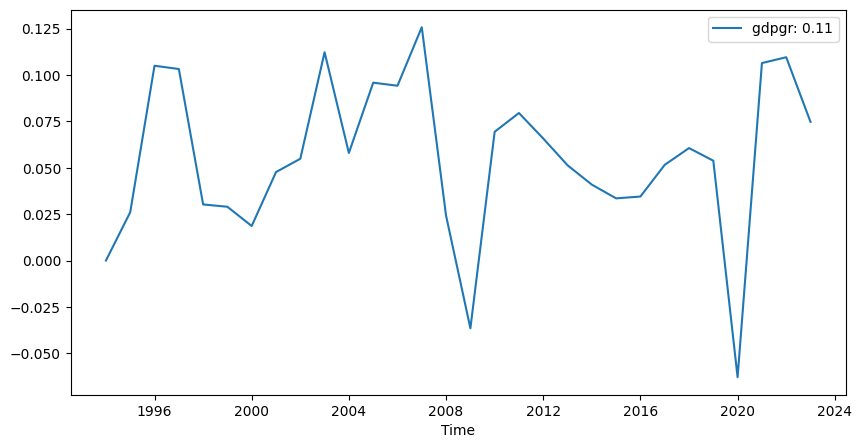

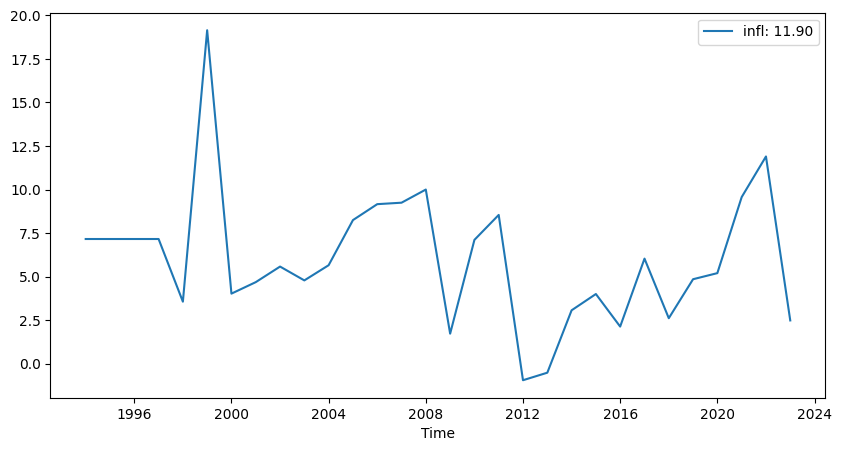

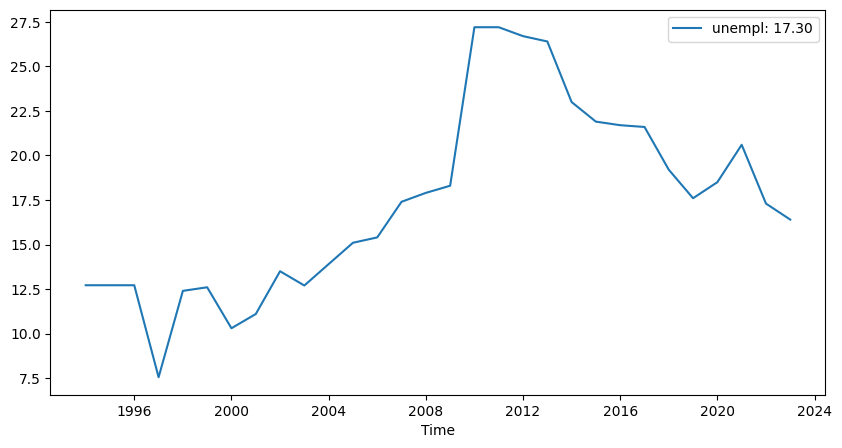

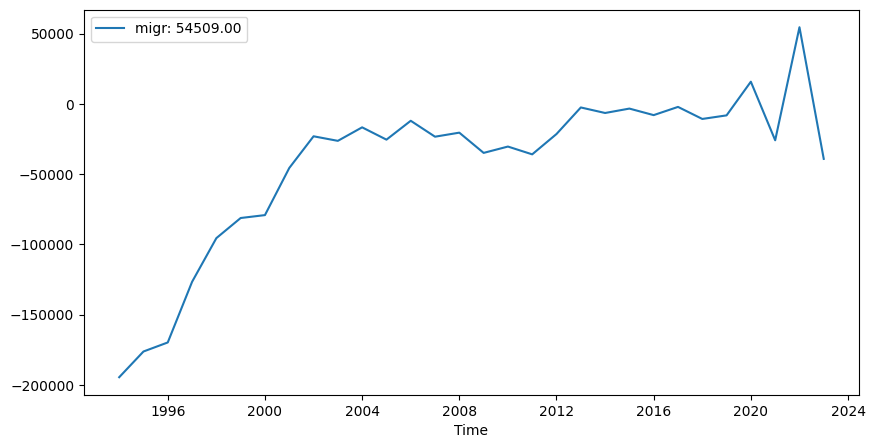

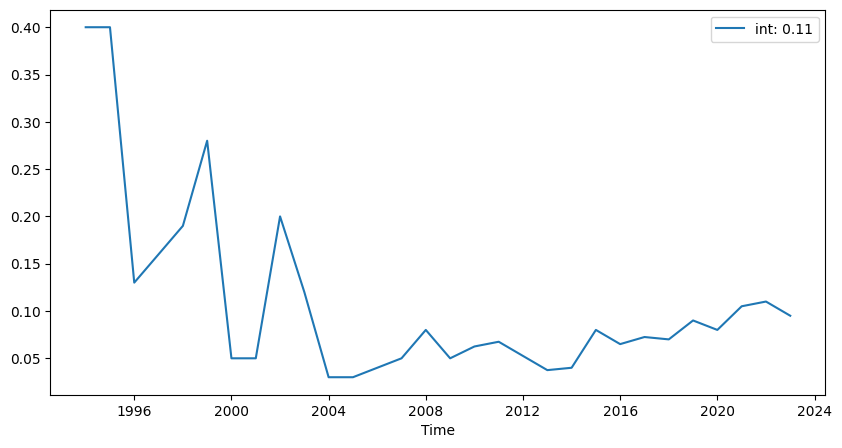

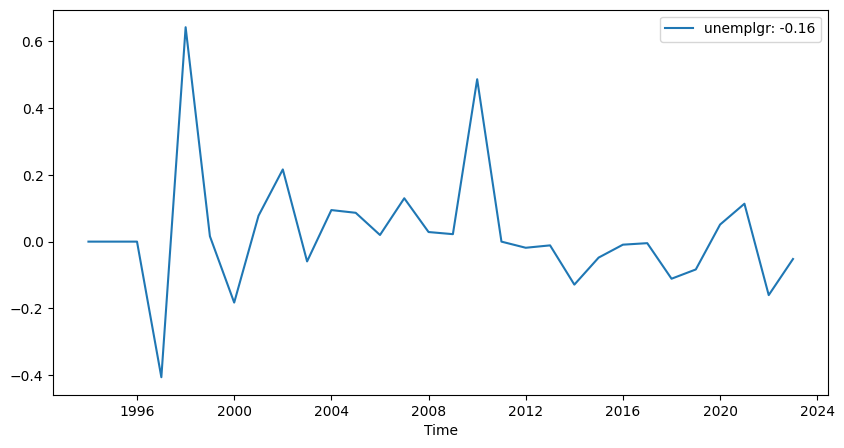

In [ ]:
##################################### Plots of the key variables ######################
# Plot all variables in the data dataframe separately

# Remove break columns from the data
columns_to_plot = [col for col in data.columns if not col.startswith('Break')]

# Plot each variable in the data dataframe separately
for column in columns_to_plot:
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data[column], label=column)
    plt.title(f'Time Series of {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.show()


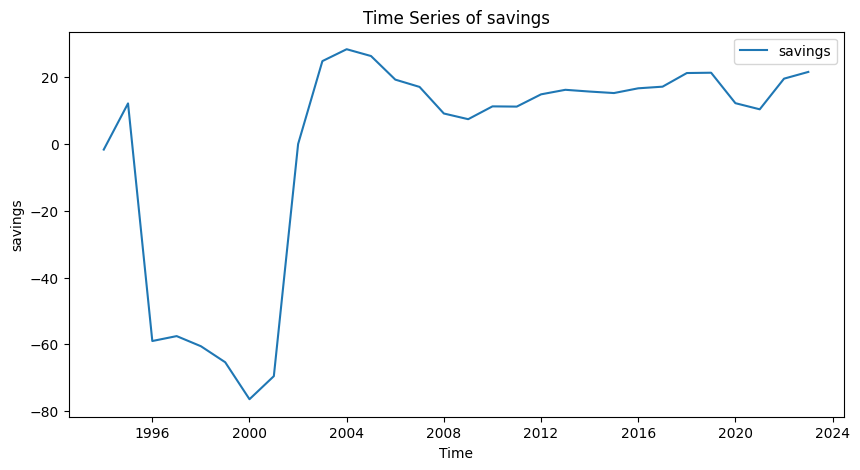

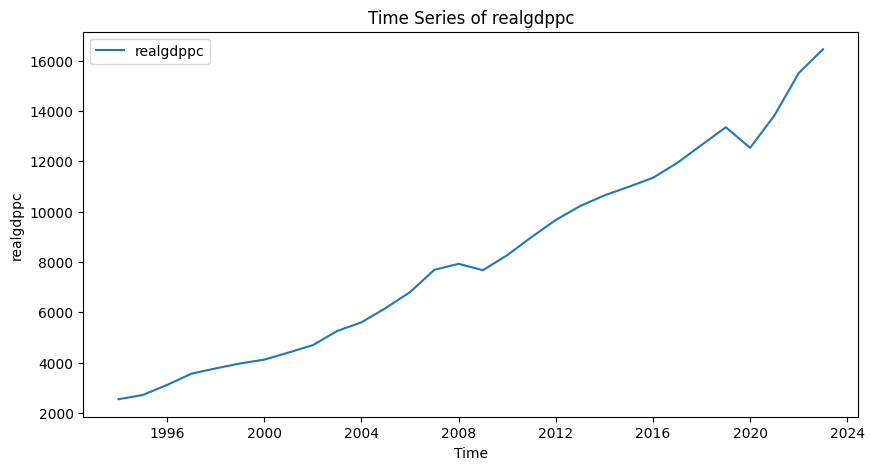

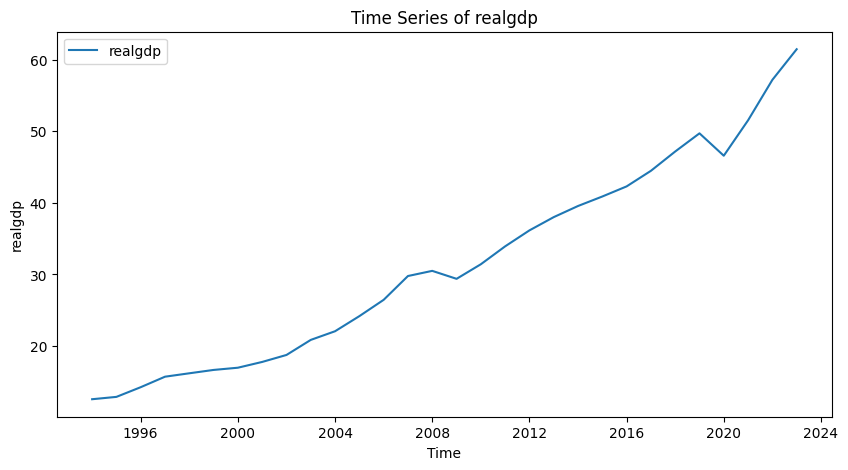

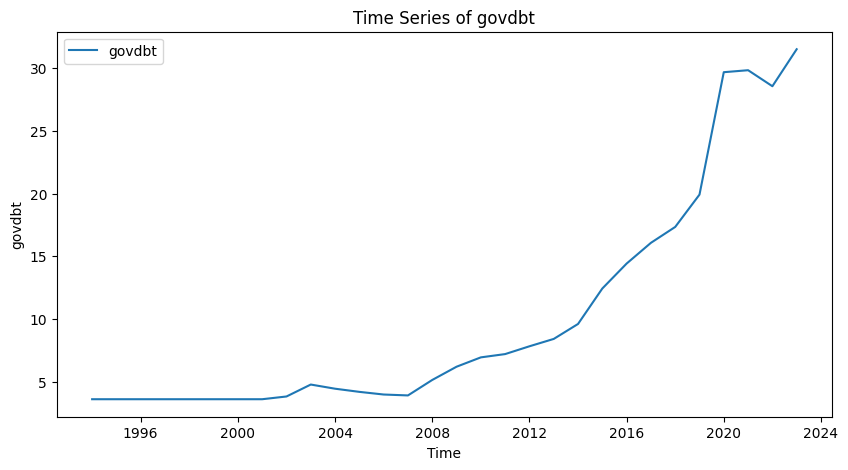

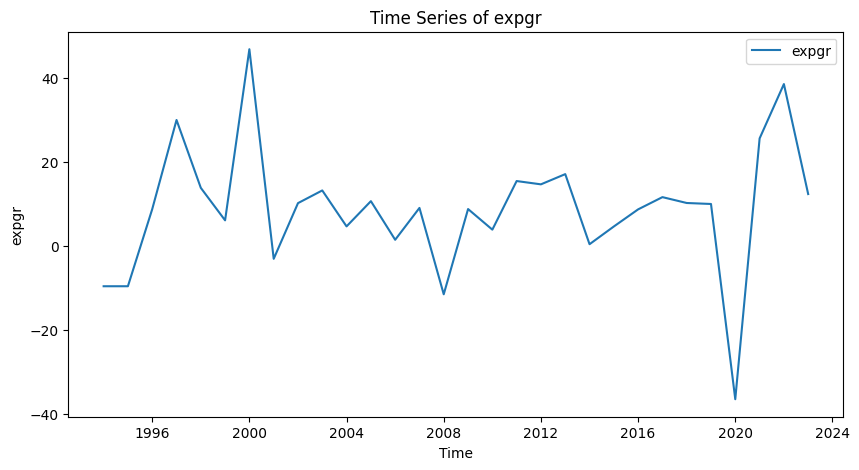

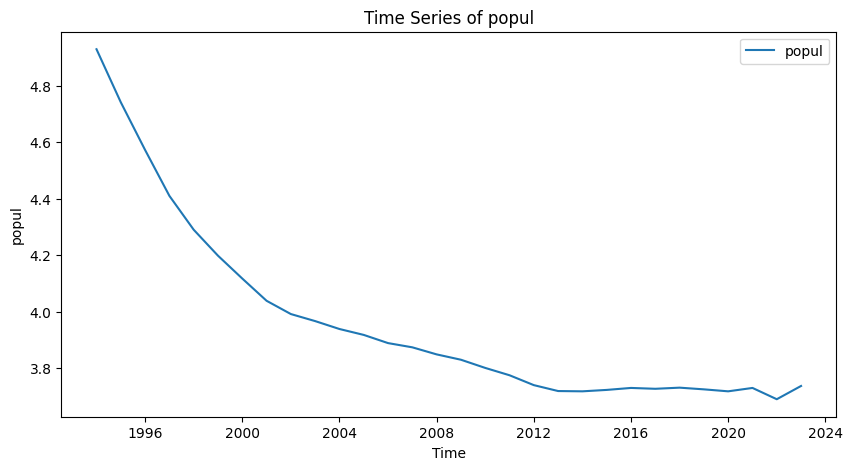

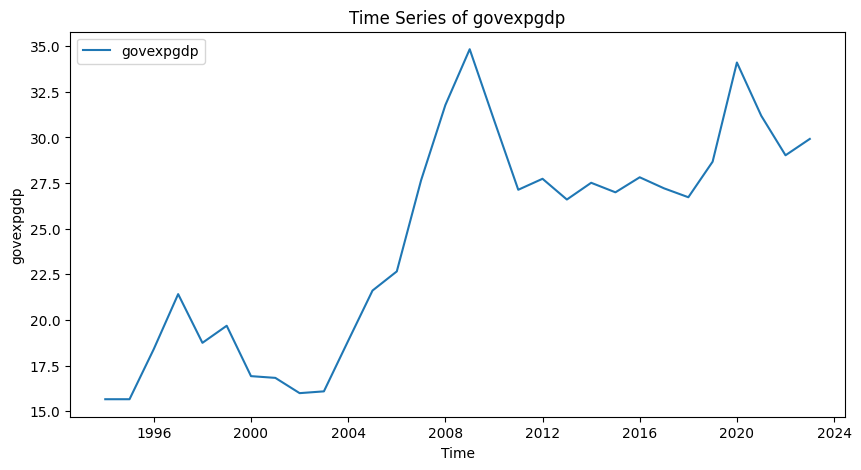

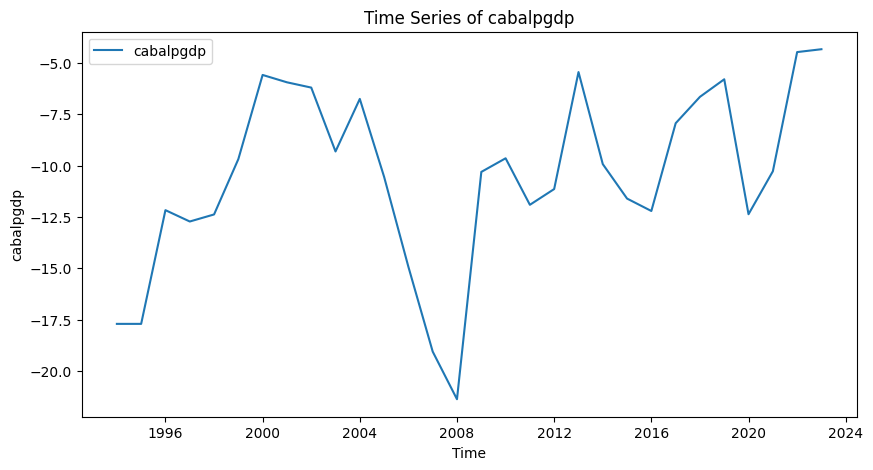

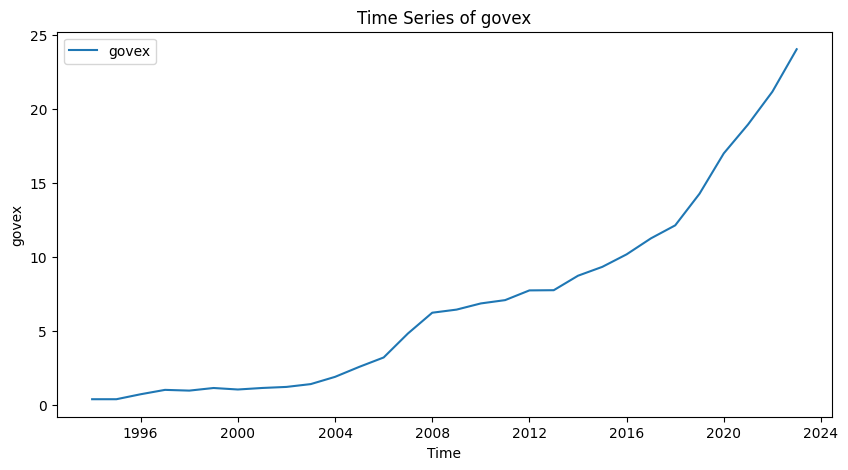

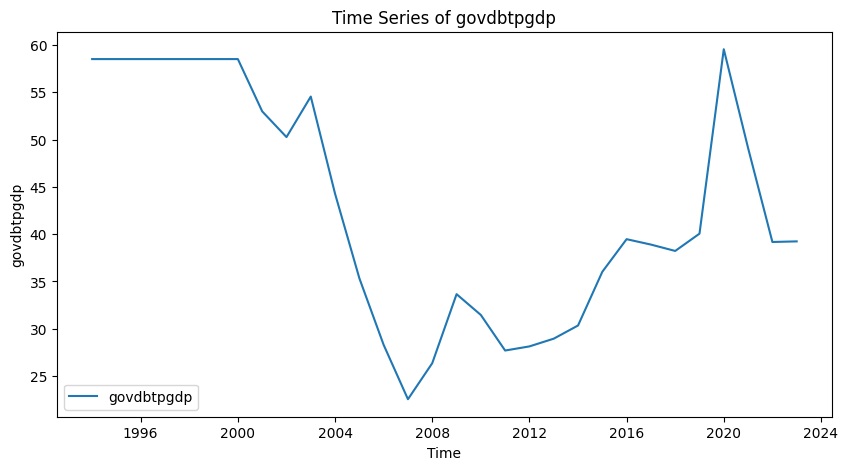

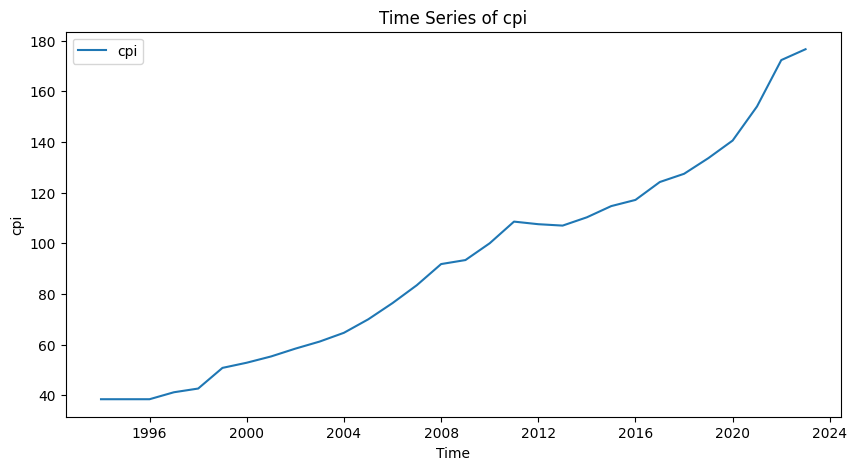

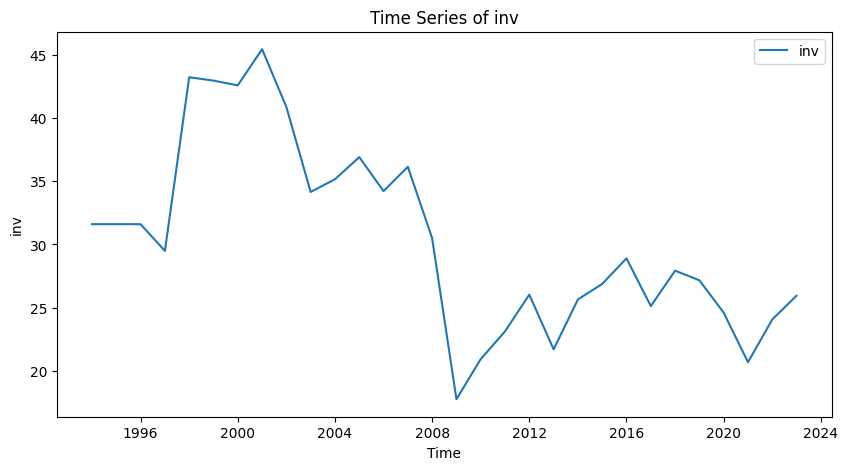

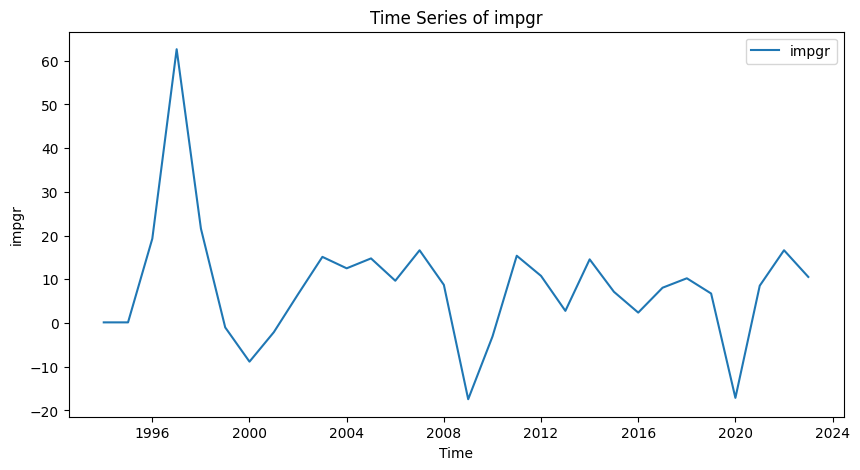

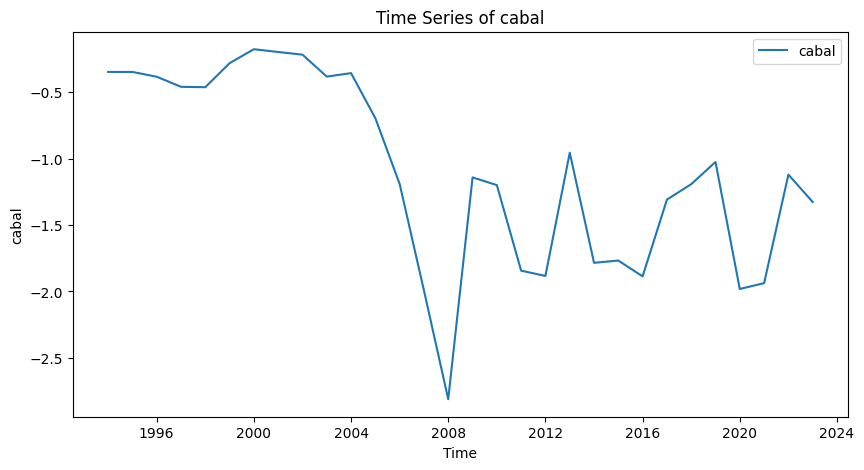

In [5]:
################################# Plot of other variables ##########################

from statsmodels.sandbox.regression.gmm import IV2SLS

rawdata=rawdata.head(30)
# Identify variables that are in rawdata but not in data
extra_vars = set(rawdata.columns) - set(data.columns)

# Plot these extra variables
for column in extra_vars:
    plt.figure(figsize=(10, 5))
    plt.plot(rawdata.index, rawdata[column], label=column)
    plt.title(f'Time Series of {column}')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.legend()
    plt.show()

In [6]:
################################### OLS with growth data ######################################

import statsmodels.api as sm

# Define the dependent variable
y = data['gdpgr']

# Define the independent variables
X = data[['int', 'unemplgr', 'migr', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022']]

# Add lagged variables
X['gdpgr_lag'] = data['gdpgr'].shift(1)
X['migr_lag'] = data['migr'].shift(1)

# Drop rows with NaN values (due to lagging)
X = X.dropna()
y = y.loc[X.index]

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the OLS model with robust covariance type
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  gdpgr   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     1.308
Date:                Tue, 10 Dec 2024   Prob (F-statistic):              0.296
Time:                        17:56:00   Log-Likelihood:                 57.817
No. Observations:                  29   AIC:                            -95.63
Df Residuals:                      19   BIC:                            -81.96
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0463      0.038      1.202      0.2

/tmp/ipykernel_2286/1229584155.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['gdpgr_lag'] = data['gdpgr'].shift(1)
/tmp/ipykernel_2286/1229584155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['migr_lag'] = data['migr'].shift(1)


In [7]:
################################### OLS with level data ######################################

import statsmodels.api as sm

# Define the dependent variable
y2 = rawdata['realgdppc']


rawdata['realgdppc_lag'] = rawdata['realgdppc'].shift(1)

# Define the independent variables
X2 = rawdata[['int', 'unempl', 'migr', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022','realgdppc_lag']]

# Add trend variable
rawdata['trend'] = np.arange(len(rawdata))

# Include trend in the independent variables
X2['trend'] = rawdata['trend']

# Drop rows with NaN values (due to lagging)
X2 = X2.dropna()
y2 = y2.loc[X2.index]

# Add a constant to the independent variables

X2 = sm.add_constant(X2)

# Fit the OLS model with robust covariance type
model2 = sm.OLS(y2, X2).fit()

# Print the summary of the regression
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:              realgdppc   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     711.2
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           4.44e-22
Time:                        17:56:00   Log-Likelihood:                -196.55
No. Observations:                  29   AIC:                             413.1
Df Residuals:                      19   BIC:                             426.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           214.2596    440.358      0.487

/tmp/ipykernel_2286/2207890817.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2['trend'] = rawdata['trend']


In [8]:
############################### OLS with log GDP ######################################

# Generate the log of realgdppc
rawdata['log_realgdppc'] = np.log(rawdata['realgdppc'])

# Define the dependent variable
y3 = rawdata['log_realgdppc']

# Define the independent variables
X3 = rawdata[['int', 'unempl', 'migr', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022']]

# Add lagged variables
X3['log_realgdppc_lag'] = rawdata['log_realgdppc'].shift(1)

# Add trend variable
X3['trend'] = rawdata['trend']

# Drop rows with NaN values (due to lagging)
X3 = X3.dropna()
y3 = y3.loc[X3.index]

# Add a constant to the independent variables
X3 = sm.add_constant(X3)

# Fit the OLS model with robust covariance type
model3 = sm.OLS(y3, X3).fit()

# Print the summary of the regression
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:          log_realgdppc   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     813.4
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           1.24e-22
Time:                        17:56:00   Log-Likelihood:                 64.624
No. Observations:                  29   AIC:                            -109.2
Df Residuals:                      19   BIC:                            -95.57
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.3685      1.19

/tmp/ipykernel_2286/2349127147.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3['log_realgdppc_lag'] = rawdata['log_realgdppc'].shift(1)
/tmp/ipykernel_2286/2349127147.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3['trend'] = rawdata['trend']


In [9]:
#################################### OLS with several lags  of log GDP pc ##############################


from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import VAR

# Determine the optimal number of lags using AIC

# Prepare the data for VAR model
model_data = rawdata[['log_realgdppc', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022','trend']].dropna()

# Fit the VAR model
model = VAR(model_data)
lag_order = model.select_order(maxlags=1)
optimal_lags = lag_order.aic
print(f'Optimal number of lags based on AIC: {optimal_lags}')

# Add the optimal number of lags to the independent variables
for i in range(1, optimal_lags + 1):
    model_data[f'log_realgdppc_lag{i}'] = model_data['log_realgdppc'].shift(i)

# Drop rows with NaN values (due to lagging)
model_data = model_data.dropna()

# Define the dependent variable
y4 = model_data['log_realgdppc']

# Define the independent variables
X4 = model_data.drop(columns=['log_realgdppc'])

# Add a constant to the independent variables
X4 = sm.add_constant(X4)

# Fit the OLS model with robust covariance type
model4 = sm.OLS(y4, X4).fit()

# Print the summary of the regression
print(model4.summary())

Optimal number of lags based on AIC: 1
                            OLS Regression Results                            
Dep. Variable:          log_realgdppc   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     1118.
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           3.54e-26
Time:                        17:56:00   Log-Likelihood:                 61.238
No. Observations:                  29   AIC:                            -108.5
Df Residuals:                      22   BIC:                            -98.91
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [10]:
################################### OLS with several lags of realgdp ######################################

# Define the dependent variable
y5 = rawdata['realgdp']

# Define the independent variables
X5 = rawdata[['int','Break_2003', 'Break_2008', 'Break_2020', 'Break_2022']]

# Add lagged variables
X5['realgdp_lag'] = rawdata['realgdp'].shift(1)

X5['migr_lag'] = rawdata['migr'].shift(1)

# Add trend variable
X5['trend'] = rawdata['trend']

# Drop rows with NaN values (due to lagging)
X5 = X5.dropna()
y5 = y5.loc[X5.index]

# Add a constant to the independent variables
X5 = sm.add_constant(X5)

# Fit the OLS model with robust covariance type
model5 = sm.OLS(y5, X5).fit()

# Print the summary of the regression
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                realgdp   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     477.6
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           4.13e-21
Time:                        17:56:00   Log-Likelihood:                -40.878
No. Observations:                  29   AIC:                             99.76
Df Residuals:                      20   BIC:                             112.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.9291      1.757      0.529      

/tmp/ipykernel_2286/1275307211.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X5['realgdp_lag'] = rawdata['realgdp'].shift(1)
/tmp/ipykernel_2286/1275307211.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X5['migr_lag'] = rawdata['migr'].shift(1)
/tmp/ipykernel_2286/1275307211.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [11]:
################################## OLS with log real gdp with several lags #################################

# Generate the log of realgdp
rawdata['log_realgdp'] = np.log(rawdata['realgdp'])

# Define the dependent variable
y6 = rawdata['log_realgdp']

# Define the independent variables

X6 = rawdata[['int', 'Break_2003', 'Break_2008', 'Break_2020', 'Break_2022']]

# Add lagged variables

X6['log_realgdp_lag'] = rawdata['log_realgdp'].shift(1)

X6['migr_lag'] = rawdata['migr'].shift(1)

# Add trend variable

X6['trend'] = rawdata['trend']

# Drop rows with NaN values (due to lagging)

X6 = X6.dropna()

y6 = y6.loc[X6.index]

# Add a constant to the independent variables

X6 = sm.add_constant(X6)

# Fit the OLS model with robust covariance type

model6 = sm.OLS(y6, X6).fit()

# Print the summary of the regression

print(model6.summary())


                            OLS Regression Results                            
Dep. Variable:            log_realgdp   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     692.5
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           1.03e-22
Time:                        17:56:00   Log-Likelihood:                 63.451
No. Observations:                  29   AIC:                            -108.9
Df Residuals:                      20   BIC:                            -96.60
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.1999      0.442     

/tmp/ipykernel_2286/3256844307.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X6['log_realgdp_lag'] = rawdata['log_realgdp'].shift(1)
/tmp/ipykernel_2286/3256844307.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X6['migr_lag'] = rawdata['migr'].shift(1)
/tmp/ipykernel_2286/3256844307.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [12]:
###################################### OLS with cross product of dummy and trend###############################

# Create interaction terms between structural break variables and trend
rawdata['Break_2003_trend'] = rawdata['Break_2003'] * rawdata['trend']
rawdata['Break_2008_trend'] = rawdata['Break_2008'] * rawdata['trend']
rawdata['Break_2020_trend'] = rawdata['Break_2020'] * rawdata['trend']
rawdata['Break_2022_trend'] = rawdata['Break_2022'] * rawdata['trend']

# Define the dependent variable
y7 = rawdata['log_realgdp']

# Add lagged log real GDP variable
rawdata['log_realgdp_lag'] = rawdata['log_realgdp'].shift(1)

# Drop rows with NaN values (due to lagging)
rawdata = rawdata.dropna()

# Update the dependent variable to match the index of the independent variables
y7 = rawdata['log_realgdp']

# Define the independent variables
X7 = rawdata[['Break_2003', 'Break_2008', 'Break_2020', 'Break_2022', 'Break_2003_trend', 'Break_2008_trend', 'Break_2020_trend', 'Break_2022_trend','log_realgdp_lag']]

# Add a constant to the independent variables
X7 = sm.add_constant(X7)

# Fit the OLS model with robust covariance type
model7 = sm.OLS(y7, X7).fit()

# Print the summary of the regression
print(model7.summary())

                            OLS Regression Results                            
Dep. Variable:            log_realgdp   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     818.8
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           1.17e-22
Time:                        17:56:00   Log-Likelihood:                 68.317
No. Observations:                  29   AIC:                            -116.6
Df Residuals:                      19   BIC:                            -103.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4306      0.218  

In [13]:
##############################  RR paper OLS #####################################

# Define the dependent variable
y_rr = rawdata['log_realgdp']

# Define the independent variables
X_rr = rawdata[['log_realgdp_lag', 'int', 'trend', 'Break_2022']]

# Add additional lags
X_rr['log_realgdp_lag2'] = rawdata['log_realgdp'].shift(2)
X_rr['int_lag1'] = rawdata['int'].shift(1)
X_rr['int_lag2'] = rawdata['int'].shift(2)

# Drop rows with NaN values (due to lagging)
X_rr = X_rr.dropna()
y_rr = y_rr.loc[X_rr.index]

# Add a constant to the independent variables
X_rr = sm.add_constant(X_rr)

# Fit the OLS model with robust covariance type
model_rr = sm.OLS(y_rr, X_rr).fit()

# Print the summary of the regression
print(model_rr.summary())

                            OLS Regression Results                            
Dep. Variable:            log_realgdp   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     462.8
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           7.47e-20
Time:                        17:56:00   Log-Likelihood:                 54.837
No. Observations:                  27   AIC:                            -93.67
Df Residuals:                      19   BIC:                            -83.31
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.4113      0.490  

/tmp/ipykernel_2286/1277735175.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_rr['log_realgdp_lag2'] = rawdata['log_realgdp'].shift(2)
/tmp/ipykernel_2286/1277735175.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_rr['int_lag1'] = rawdata['int'].shift(1)
/tmp/ipykernel_2286/1277735175.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [14]:
###################################### detrended variables ######################################


from statsmodels.tsa.tsatools import detrend


# Detrend the variables
rawdata['detrended_realgdp'] = detrend(rawdata['realgdp'])
rawdata['detrended_int'] = detrend(rawdata['int'])
rawdata['detrended_migr'] = detrend(rawdata['migr'])

# Add lagged detrended real GDP
rawdata['detrended_realgdp_lag'] = rawdata['detrended_realgdp'].shift(1)

# Drop rows with NaN values (due to lagging)
rawdata = rawdata.dropna()

# Define the dependent variable
y_detrended = rawdata['detrended_realgdp']

# Define the independent variables
X_detrended = rawdata[['detrended_realgdp_lag', 'detrended_int', 'detrended_migr', 'Break_2022', 'Break_2003', 'Break_2008', 'Break_2020']]

# Add a constant to the independent variables
X_detrended = sm.add_constant(X_detrended)

# Fit the OLS model with robust covariance type
model_detrended = sm.OLS(y_detrended, X_detrended).fit()

# Print the summary of the regression
print(model_detrended.summary())

                            OLS Regression Results                            
Dep. Variable:      detrended_realgdp   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     18.14
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           2.22e-07
Time:                        17:56:00   Log-Likelihood:                -33.592
No. Observations:                  28   AIC:                             83.18
Df Residuals:                      20   BIC:                             93.84
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.06

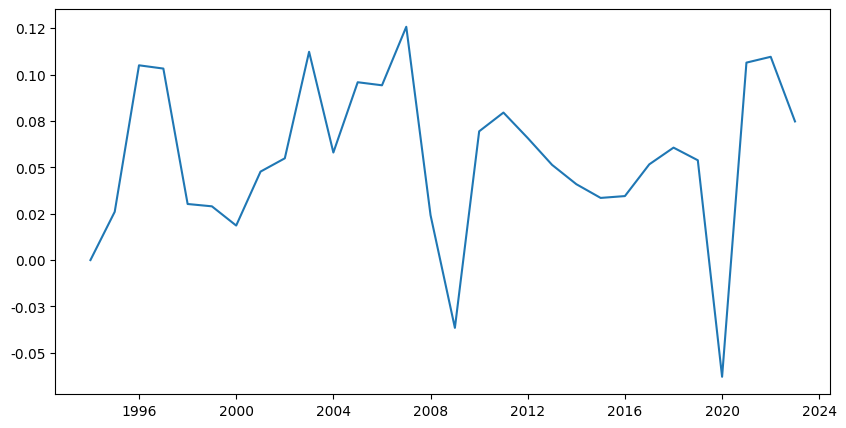

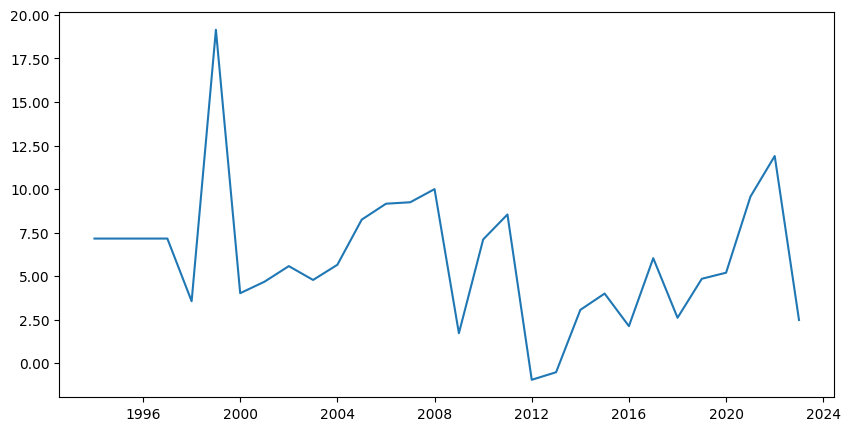

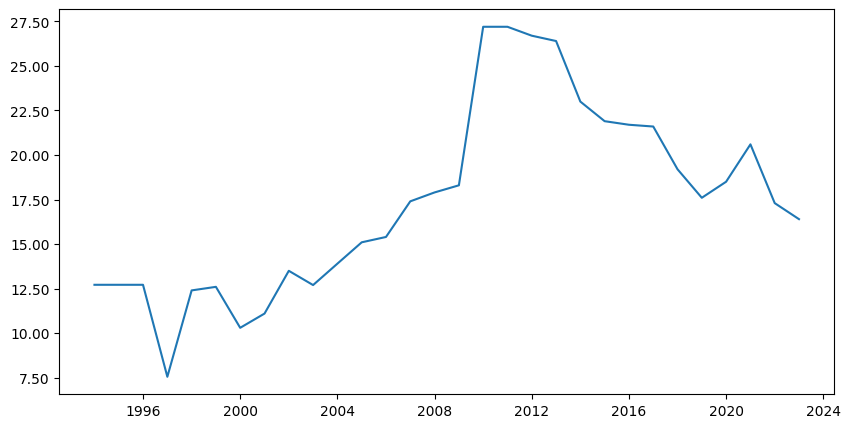

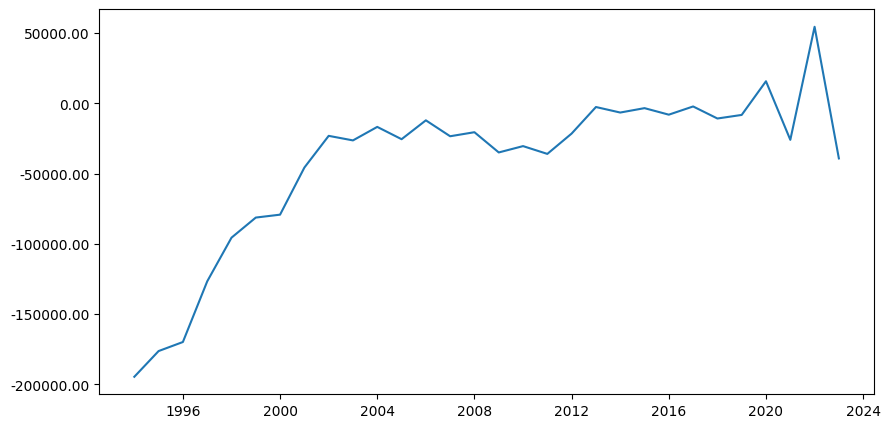

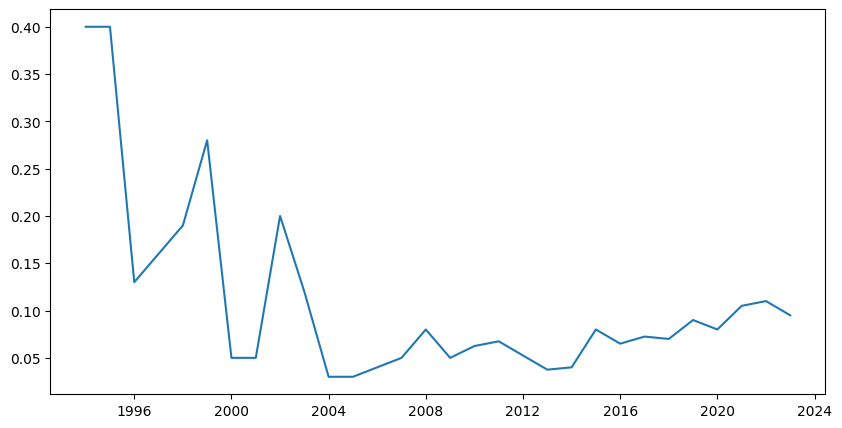

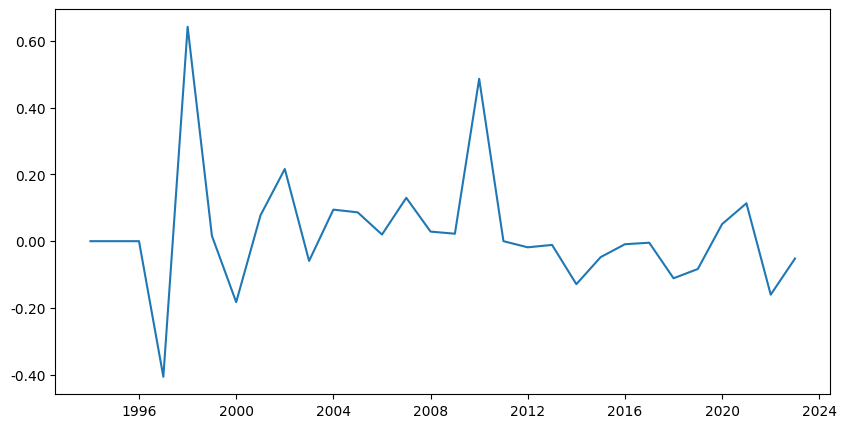

In [ ]:
##################################### Plots of the key variables for slides ######################
# Plot all variables in the data dataframe separately

# Remove break columns from the data
columns_to_plot = [col for col in data.columns if not col.startswith('Break')]

# Plot each variable in the data dataframe separately
for column in columns_to_plot:
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data[column], label=column)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.show()



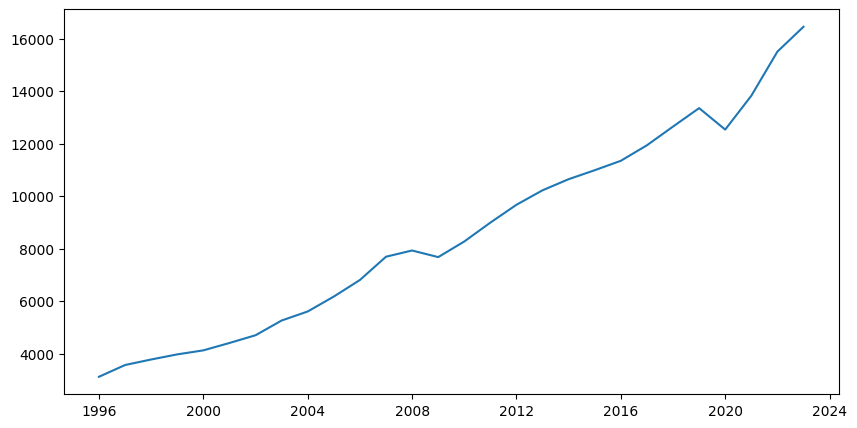

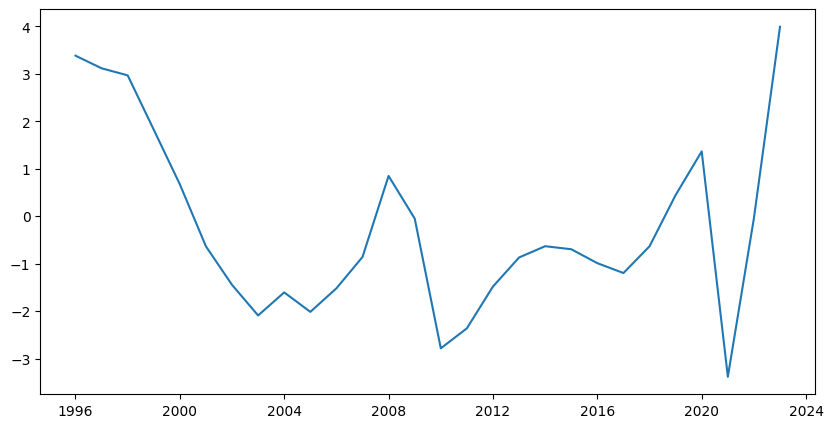

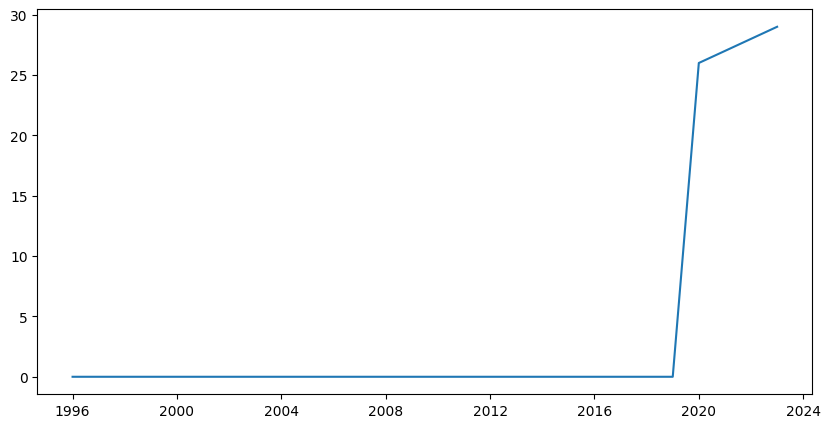

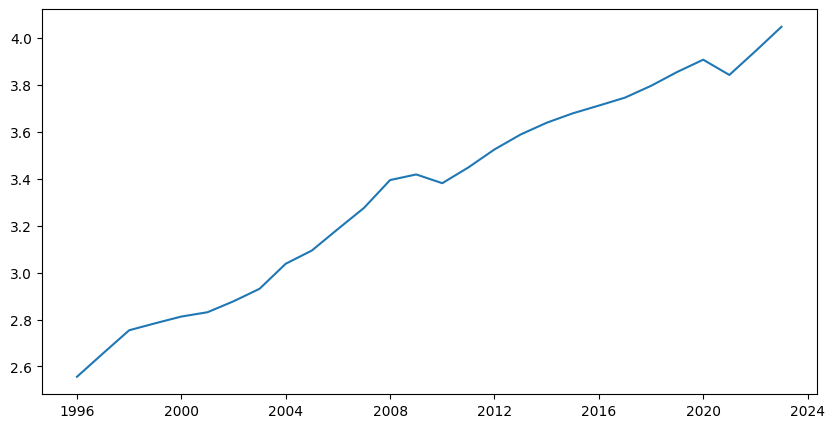

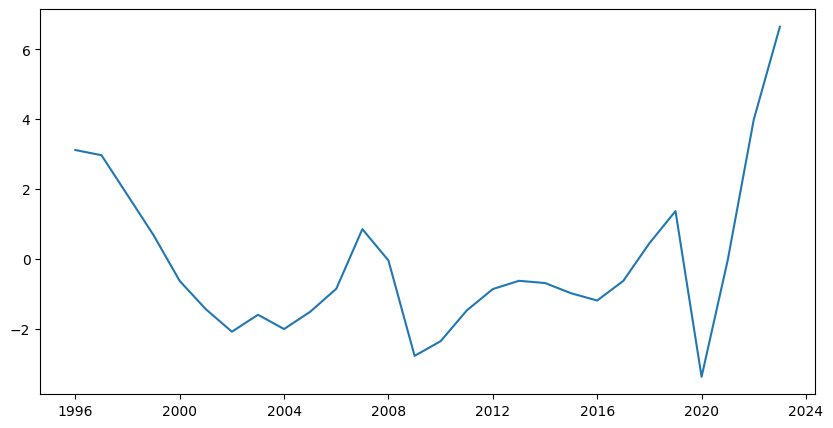

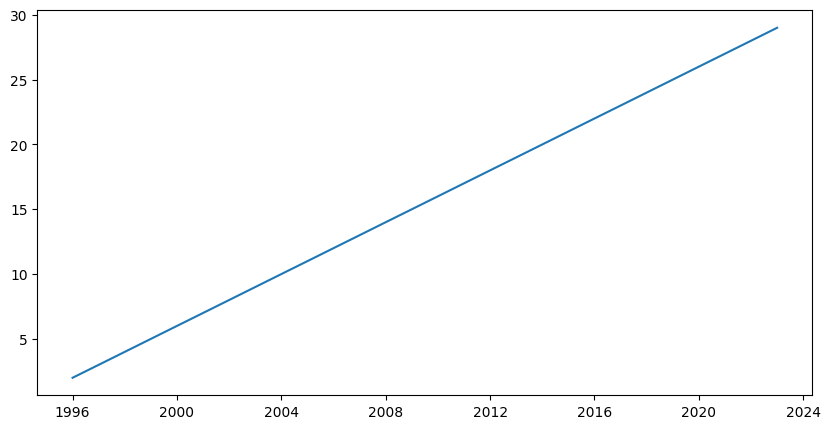

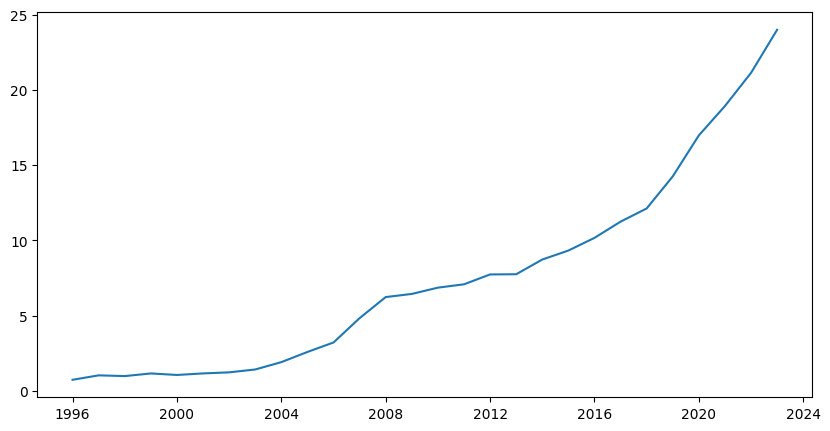

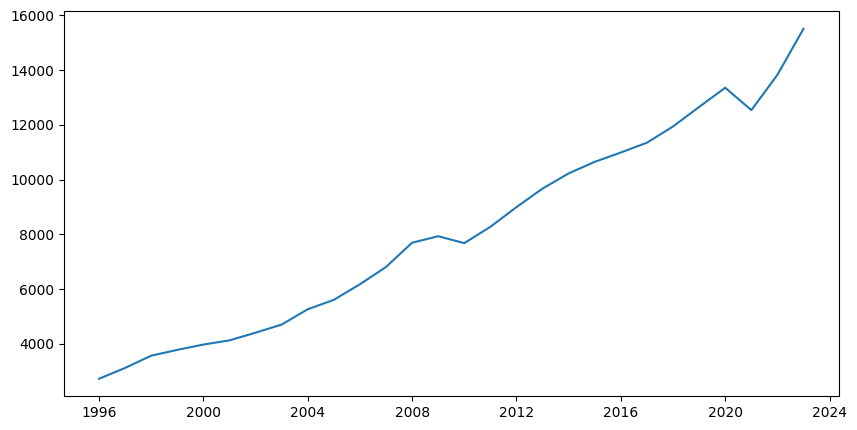

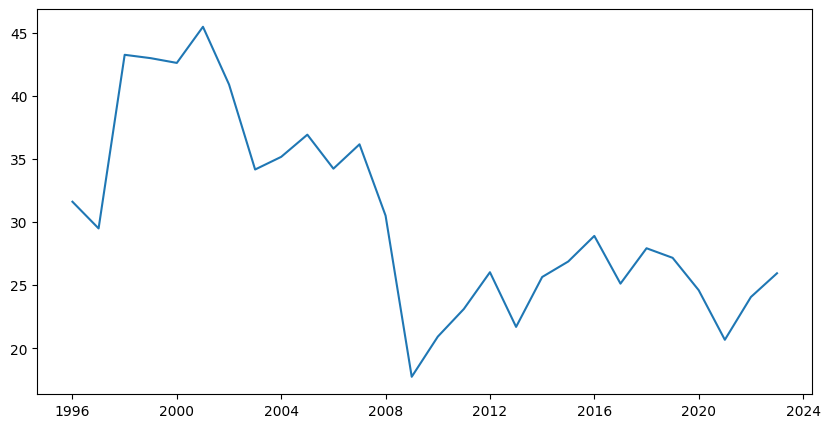

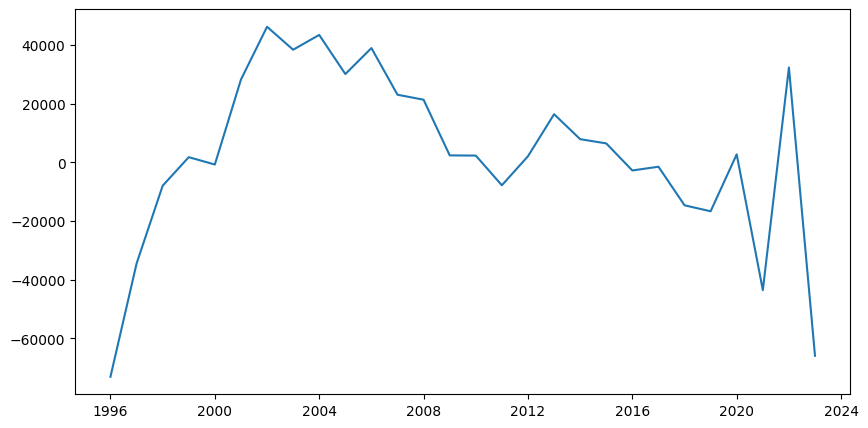

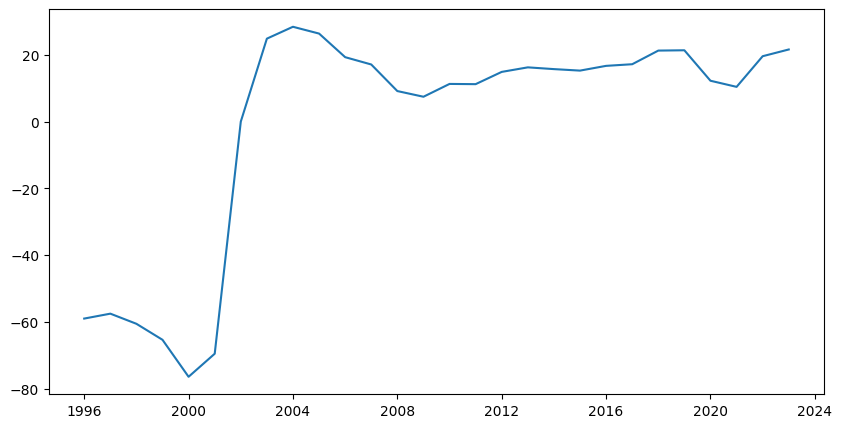

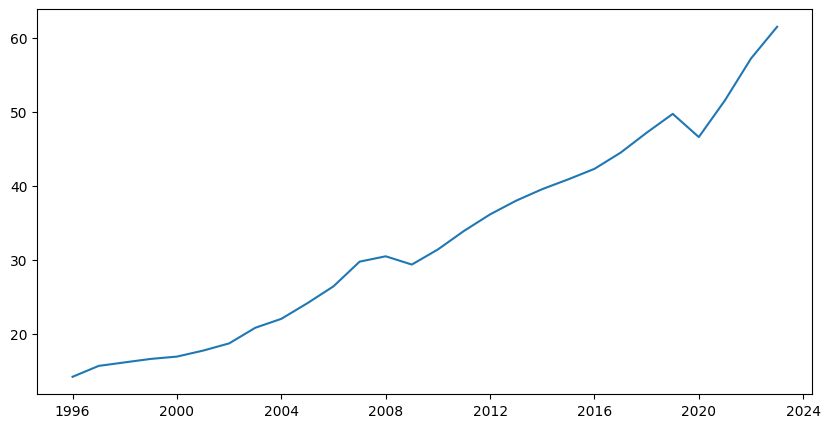

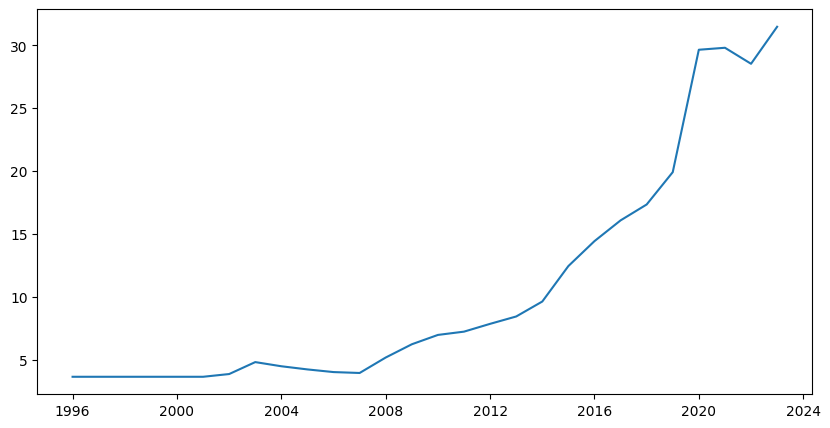

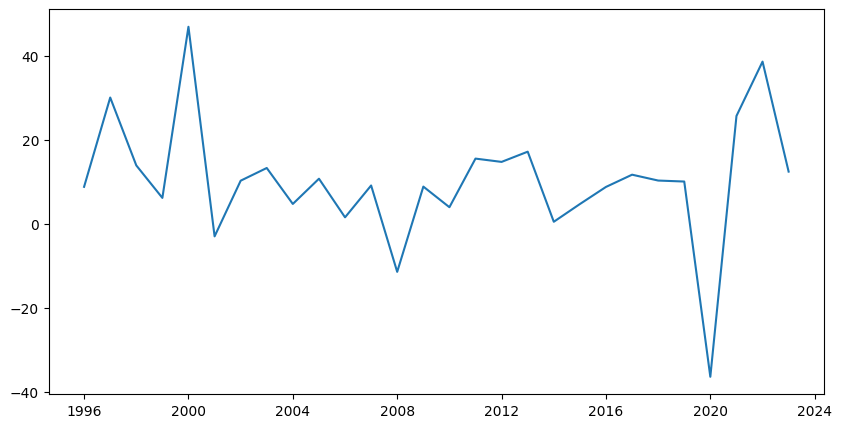

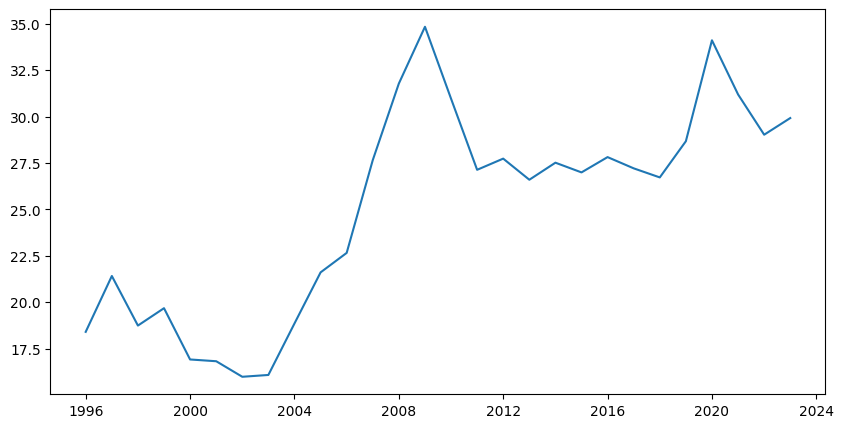

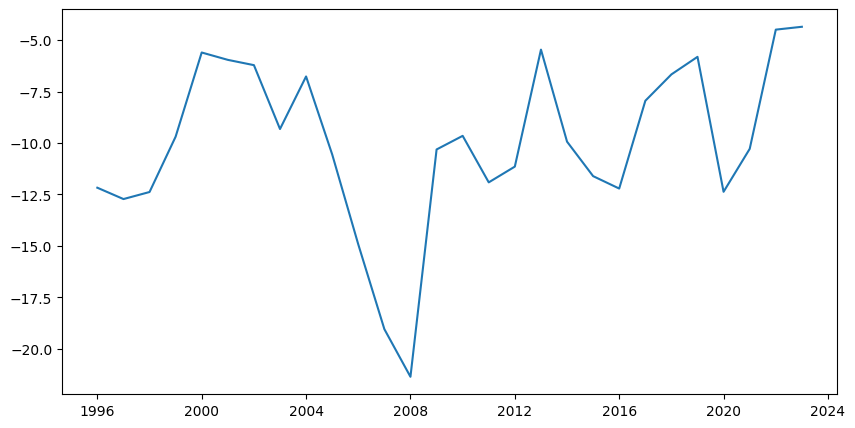

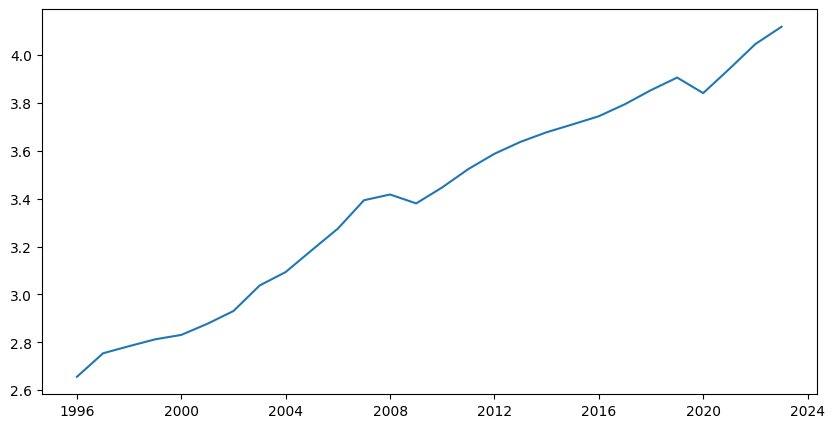

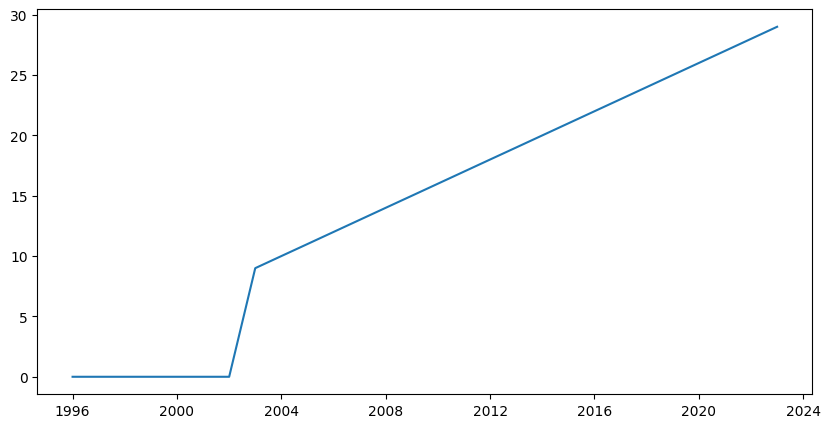

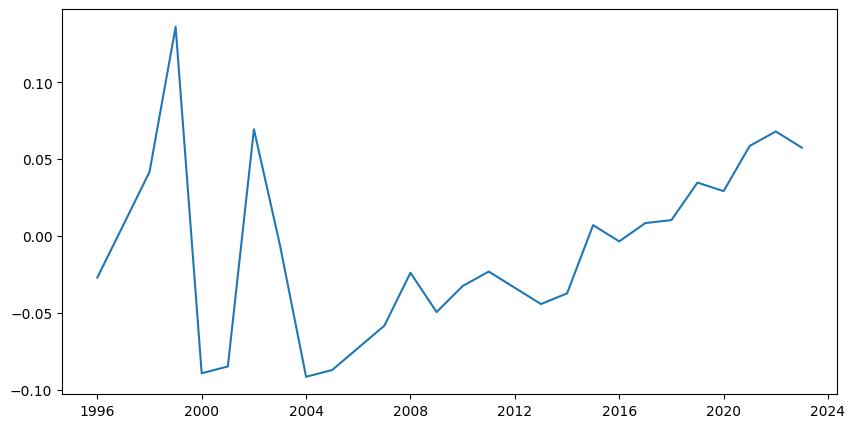

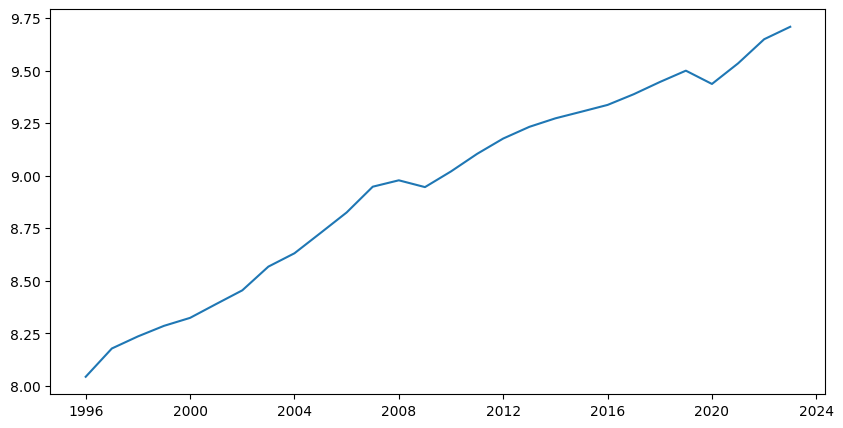

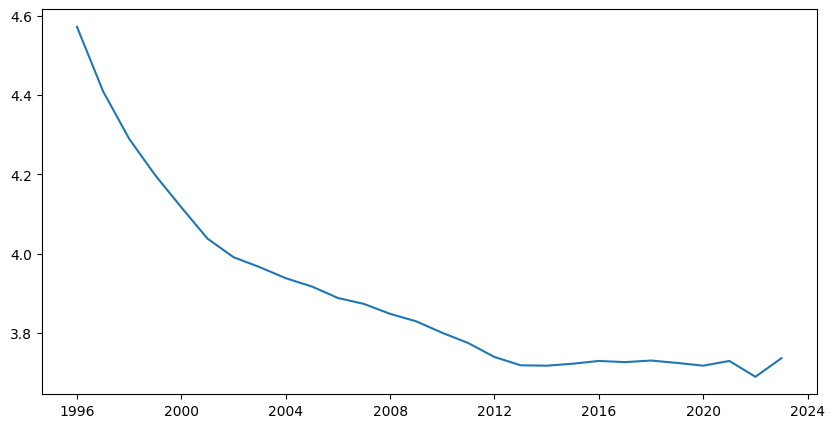

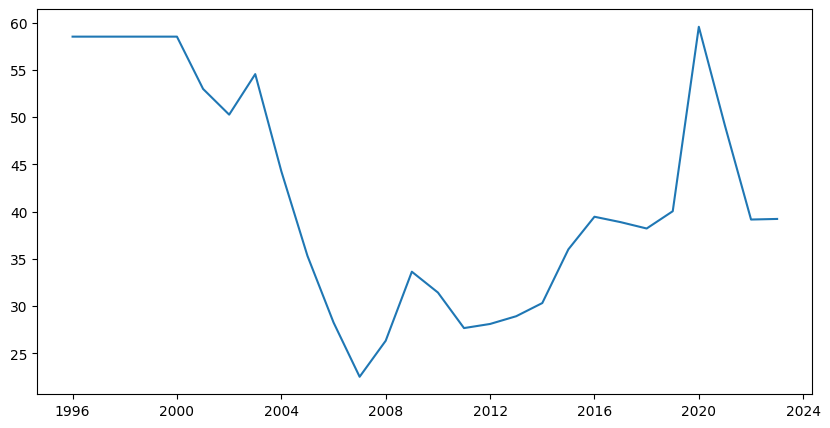

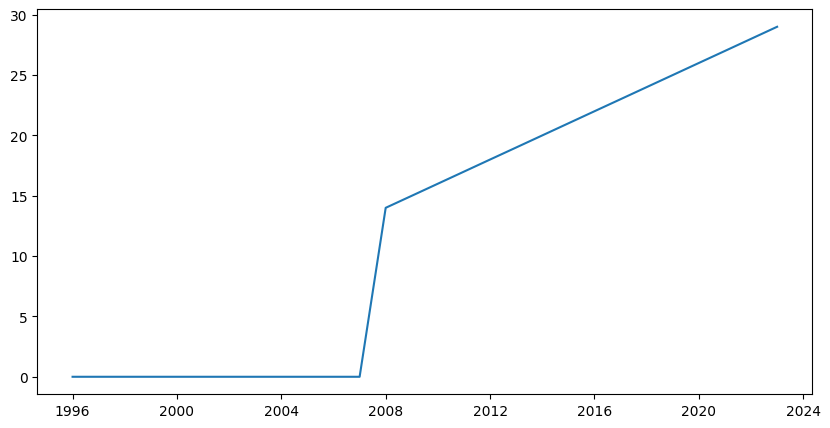

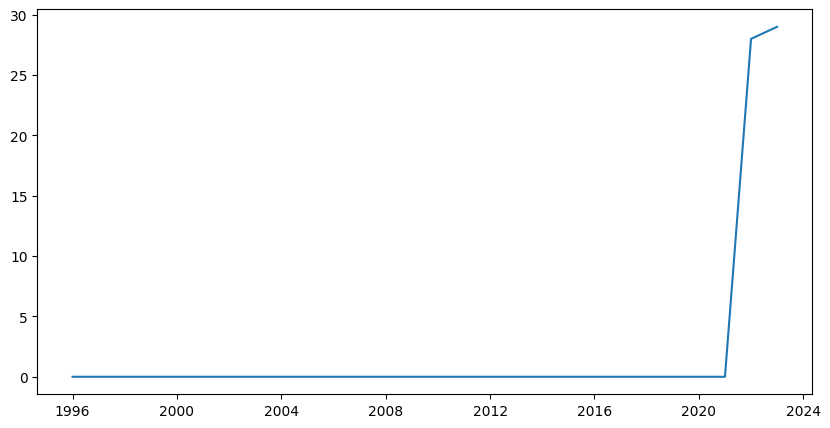

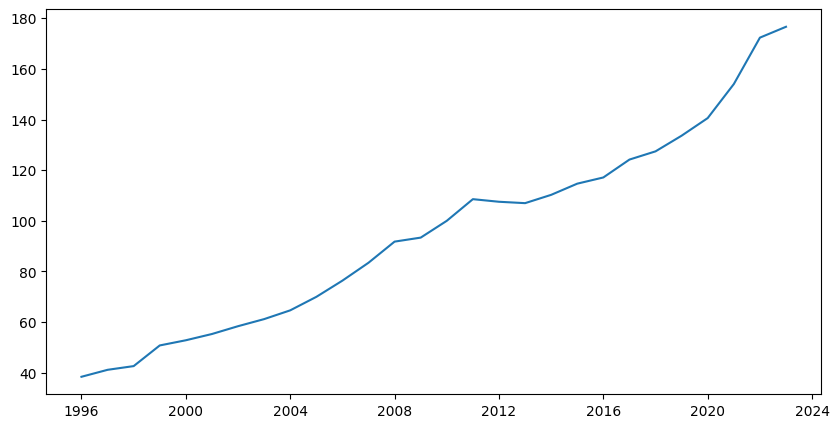

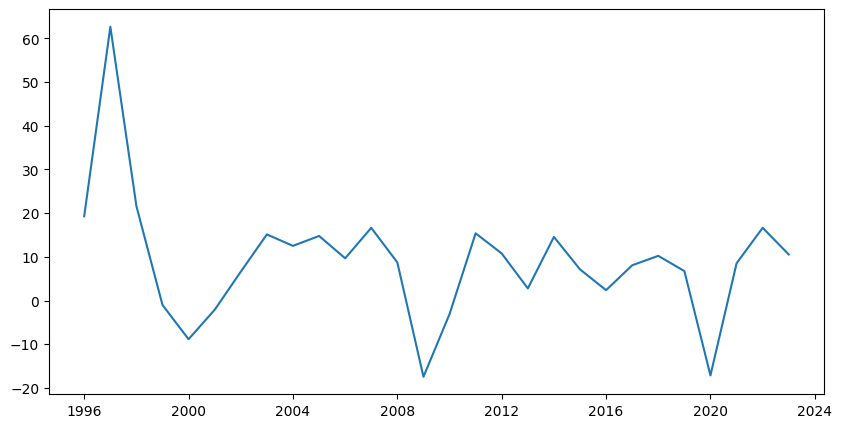

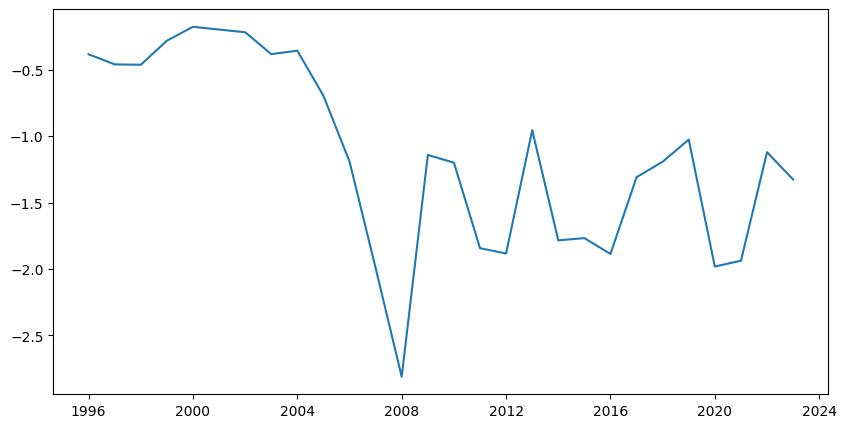

In [30]:
################################# Plot of other variables for slides ##########################

from statsmodels.sandbox.regression.gmm import IV2SLS

rawdata=rawdata.head(30)
# Identify variables that are in rawdata but not in data
extra_vars = set(rawdata.columns) - set(data.columns)

# Plot these extra variables
for column in extra_vars:
    plt.figure(figsize=(10, 5))
    plt.plot(rawdata.index, rawdata[column], label=column)
    plt.show()

